<a href="https://colab.research.google.com/github/Srinathshadow/Customer-Segmentation-using-Clustering-with-ML/blob/main/Machine_Learning4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# import and inspect
import pandas as pd

df = pd.read_excel("/content/sample_data/online_retail_II.xlsx")
print(df.head())
print(df.info())
print(df.describe(include='all'))


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invo

In [9]:
# 2. Data Cleaning
print("Missing values before handling:")
print(df.isnull().sum())

Missing values before handling:
Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


In [10]:
print("\nDuplicate rows before dropping:")
print(df.duplicated().sum())


Duplicate rows before dropping:
6865


In [11]:
df.drop_duplicates(inplace=True)

In [12]:
# Handle missing Customer ID (drop rows without it)
df = df.dropna(subset=["Customer ID"])

print("\nMissing values after handling:")
print(df.isnull().sum())
print("\nDuplicate rows after dropping:")
print(df.duplicated().sum())


Missing values after handling:
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

Duplicate rows after dropping:
0


In [13]:
# 3. Feature Engineering (RFM Model)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [14]:
rfm = df.groupby('Customer ID').agg({
'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
'Invoice': 'nunique',
'Price': 'sum'
}).reset_index()
rfm.rename(columns={'InvoiceDate': 'Recency',
'Invoice': 'Frequency',
'Price': 'Monetary'}, inplace=True)
print("\nRFM head:")
print(rfm.head())


RFM head:
   Customer ID  Recency  Frequency  Monetary
0      12346.0       67         15    565.42
1      12347.0        3          2    162.95
2      12348.0       74          1     14.39
3      12349.0       43          4    899.49
4      12351.0       11          1     49.46


In [15]:
# 4. Normalization
from sklearn.preprocessing import StandardScaler
features = ['Recency', 'Frequency', 'Monetary']

X = rfm[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nScaled features:")
print(pd.DataFrame(X_scaled, columns=features).head())


Scaled features:
    Recency  Frequency  Monetary
0 -0.248511   0.956994  0.137966
1 -0.900473  -0.336439 -0.140870
2 -0.177203  -0.435934 -0.243795
3 -0.492997  -0.137449  0.369415
4 -0.818977  -0.435934 -0.219498


In [16]:
# 5. K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [17]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

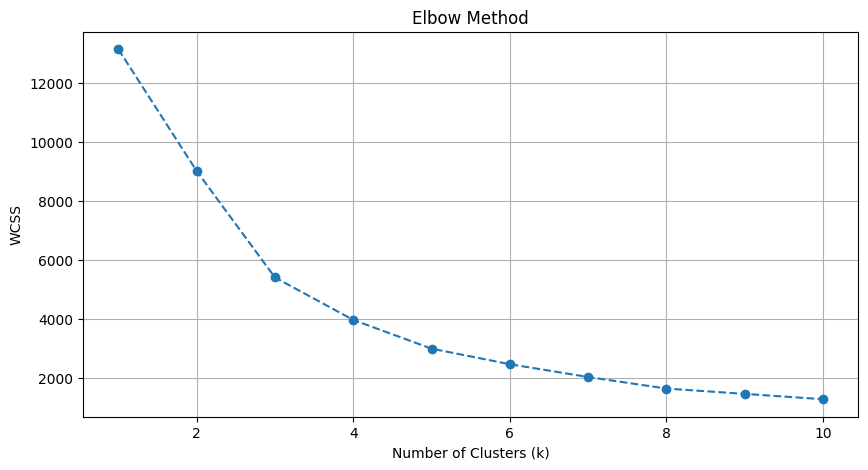

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [19]:
# Silhouette Scores
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

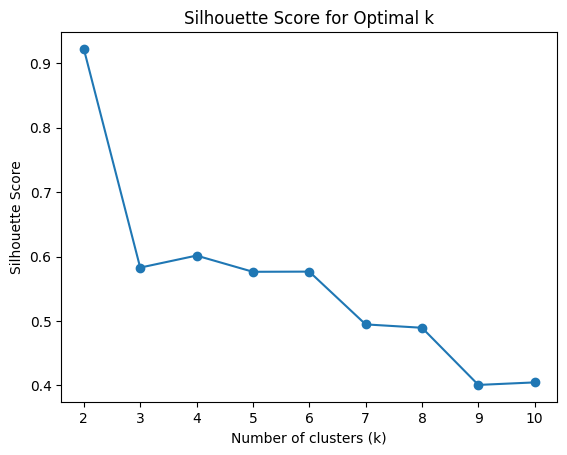

In [20]:
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

In [21]:
# Final KMeans with chosen k (say 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

In [22]:
# 6. Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

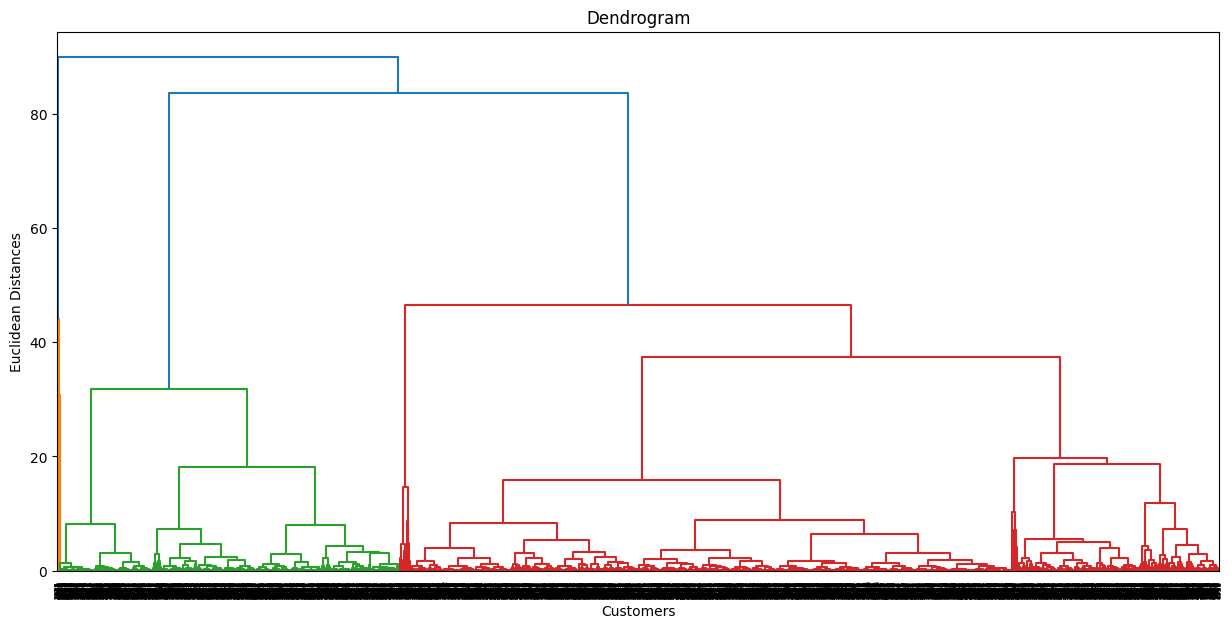

In [23]:
plt.figure(figsize=(15, 7))
dendro = dendrogram(linkage(X_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show()

In [24]:
agg_clustering = AgglomerativeClustering(n_clusters=4)
rfm['Hierarchical_Cluster'] = agg_clustering.fit_predict(X_scaled)

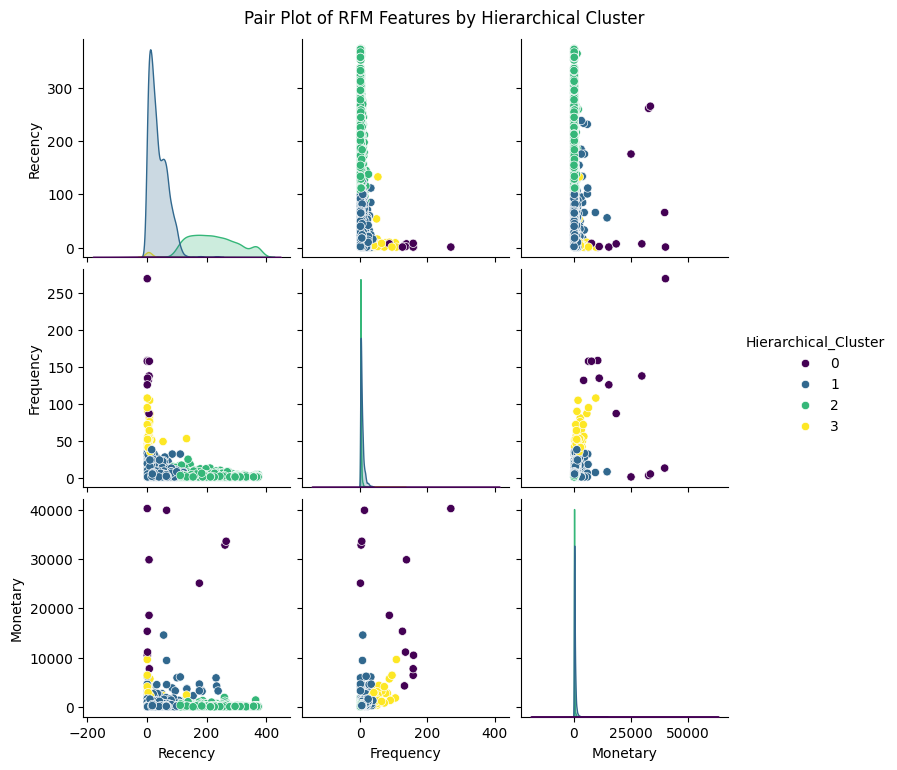

In [25]:
# 7. Visualization
sns.pairplot(rfm[features + ['Hierarchical_Cluster']],
hue='Hierarchical_Cluster', palette='viridis')
plt.suptitle('Pair Plot of RFM Features by Hierarchical Cluster', y=1.02)
plt.show()

In [26]:
# 8. Insights
cluster_means = rfm.groupby('Hierarchical_Cluster')[features].mean()
print("\nMean RFM values for each Hierarchical cluster:")
print(cluster_means)


Mean RFM values for each Hierarchical cluster:
                         Recency   Frequency      Monetary
Hierarchical_Cluster                                      
0                      61.692308  106.538462  21197.218462
1                      36.817497    5.673329    355.598699
2                     224.255469    2.110937    118.347378
3                       9.710526   57.500000   2449.298211
